
**House Prices: Advanced Regression Techniques** 

Note that the competition data is separated into training and test sets. Each record includes the property value of the house and attributes such as street type, year of construction, roof type, basement condition, etc. The features represent multiple data types. Year of construction, for example, is represented with integers roof type is a discrete categorical feature, other features are represented with floating point numbers.

In [1]:
!pip install mxnet
!pip install d2l

     |████████████████████████████████| 68.7MB 52kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
import os
from mxnet import gluon
import zipfile
import tarfile

%matplotlib inline
import d2l
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
import pandas as pd
npx.set_np()

In [0]:
# Saved in the d2l package for later use
DATA_HUB = dict()

In [0]:
# Saved in the d2l package for later use
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [0]:
# Saved in the d2l package for later use
def download(name, cache_dir='../data'):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, "%s doesn't exist" % name
    url, sha1 = DATA_HUB[name]
    d2l.mkdir_if_not_exist(cache_dir)
    return gluon.utils.download(url, cache_dir, sha1_hash=sha1)

In [0]:
# Saved in the d2l package for later use
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext == '.tar' or ext == '.gz':
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted'
    fp.extractall(base_dir)
    if folder:
        return base_dir + '/' + folder + '/'
    else:
        return data_dir + '/'

In [0]:
# Saved in the d2l package for later use
def download_all():
    """Download all files in the DATA_HUB"""
    for name in DATA_HUB:
        download(name)

In [0]:
# Saved in the d2l package for later use
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

# Saved in the d2l package for later use
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [17]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data  = pd.read_csv(download('kaggle_house_test'))

In [18]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Letʼs take a look at the first 4 and last 2 features as well as the label (SalePrice) from the first 4 examples.

In [19]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [0]:
# Remove ID data as does not carry any information for prediction purposes
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

We replace missing values with the mean. This is a reasonable strategy if features are missing at random. 

To adjust them to a common scale, we rescale them to zero mean and unit variance.

In [0]:
# Data Preprocessing
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

all_features[numeric_features] = all_features[numeric_features].apply(lambda x: 
                                                                      (x - x.mean()) / (x.std()))

“normalizing” the data is that it brings all features to the same order of magnitude.

In [0]:
# After standardizing the data all means vanish, hence we can set missing values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [23]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

We can see that this conversion increases the number of features from 79 to 331.

We can use the values attribute, so that we can extract the NumPy format from the Pandas dataframe and convert it into MXNetʼs native ndarray representation for training.

In [0]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values, dtype=np.float32)
test_features = np.array(all_features[n_train:].values, dtype=np.float32)
train_labels = np.array(train_data.SalePrice.values,
                        dtype=np.float32).reshape(-1, 1)

we train a linear model with squared loss, this provides a a sanity check to see whether there is meaningful information in the data.

In [0]:
# select loss function (objective function)
loss = gluon.loss.L2Loss()

# define model
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

We care about relative quantities more than absolute quantities.

$L$ = $\sqrt {\frac{1}{n}\sum^{n}_{i=1} (\log y_i - \log \hat y_i)^2}$

 


In [0]:
# define evaluation metric
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = np.clip(net(features), 1, float('inf'))
    return np.sqrt(2 * loss(np.log(clipped_preds), np.log(labels)).mean())

model training function.

In [0]:
# define training function
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

 model section and to adjust the hyperparameters.

In [0]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate((X_train, X_part), axis=0)
            y_train = np.concatenate((y_train, y_part), axis=0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned when we train k times in the k-fold cross- validation.

In [0]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
  
    train_l_sum, valid_l_sum = 0, 0

    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
        
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse: 0.169453, valid rmse: 0.156822
fold 1, train rmse: 0.162325, valid rmse: 0.188222
fold 2, train rmse: 0.163594, valid rmse: 0.168142
fold 3, train rmse: 0.167402, valid rmse: 0.154466
fold 4, train rmse: 0.162877, valid rmse: 0.182785
5-fold validation: avg train rmse: 0.165130, avg valid rmse: 0.170087


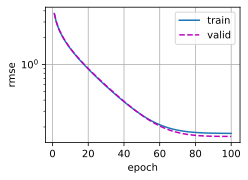

In [35]:
# Model Selection
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

We notice that sometimes the number of training errors for a set of hyper-parameters can be very low, while the number of errors for the K-fold cross-validation may be higher. This is an indicator that we are overfitting. Therefore, when we reduce the amount of training errors, we need to check whether the amount of errors in the k-fold cross-validation have also been reduced accordingly.

In [0]:
# Predict and Submit
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='rmse', yscale='log')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).asnumpy()
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

Now that we know what a good choice of hyperparameters should be, we might as well use all the data to train on it (rather than just 1 − 1/k of the data that is used in the cross-validation slices). The model that we obtain in this way can then be applied to the test set. Saving the estimates in a CSV file will simplify uploading the results to Kaggle.

train rmse 0.162621


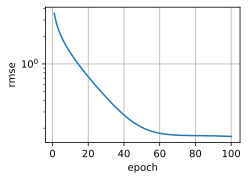

In [38]:
 train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [39]:
!ls

sample_data  submission.csv


In [0]:
from google.colab import files
files.download('submission.csv') 